# Exercise 10 - Semantic Segmentation of Aerial Images

In this notebook, the construction and training of a neural network with a U-Net architecture for the semantic segmentation of aerial/satellite images is shown. First, a U-Net model is constructed by hand, and trained from scratch. Second, the Semantic Models library for image segmentation is used, which is based on Python, Keras, and TensorFlow. With this library, other architectures for semantic segmentation can be tried out with little effort.

As a dataset, the semantic segmentation of aerial imagery dataset from 'Humans in the Loop' is used, which has been published at [kaggle](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery).

**Learning objectives:**

- Learn how to make image patches (of the size the network expects) from large satellite images
- Construct a U-Net neural network architecture with the functional API of Keras/TensorFlow
- Specify a composed loss function
- Use neural network modules for semantic segmentation with pre-trained weights
- Get to know the Intersection over Union (IoU) quality metric
- See how to identify overfitting

**Please note that this notebook takes up a lot of main memory, especially during training. Make sure you do not have several notebooks open and running, and observe the memory display at the right top of the Jupyter Hub window. If your notebook is terminated, then just restart it, and rerun the cells. Maybe some memory was still occupied in the background.**

## Install libraries

Before we can start, we need to install two libraries: `patchify` to split larger images to smaller patches, and the `Segmentation Models` library that provides architectures for semantic segmentation of images, as well as some useful classes and functions for losses, metrics, etc. You can install these libraries by executing the following cell or by executing the pip commands in a bash terminal (without the exclamation mark `!`). If you install libraries without `--user` after the `install` command (as in the following), then the libraries will be installed in the system directory of the virtual environment. However, whenever the virtual environment is restarted (e.g. when you log out, stay logged out for some time, and log back in), then the virtual environment is reset to its original state, and the installed libraries are gone. When you install with `--user` (e.g. `pip install --user patchify`) , then the libraries are installed in your home, and they will remain there until you uninstall them again. The first way has the advantage that your system stays clean from installed libraries, but you need to install these every time you need them, and in the second way, the libraries are installed 'permanently' (until you uninstall them again). 

In [2]:
!pip install patchify
!pip install segmentation_models

  Using cached patchify-0.2.3-py3-none-any.whl (6.6 kB)
  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)


## Find your GPU

**Before you continue, find a GPU on the system that is not heavily used by other users (with **nvidia-smi**), and change X to the id of this GPU.**

In [3]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 6

In [4]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.12.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:6 GPU


## Dataset

The dataset consists of aerial images of Dubai obtained from MBRSC satellites, and are annotated pixel-wise in six classes: building, land (unpaved area), road, vegetation, water, and unlabeled. There are 72 images grouped into six larger tiles. You can find the dataset in the shared folder of the Jupyter server at `~/coursematerial/GIS/DeepLearning/Dubai`. Both the images and the masks can be directly opened and viewed in the Jupyter environment. This is possible since also the masks are encoded as color images, and not as category indices. However, this color coding also requires an extra step later on to convert the color values into class indices (from 0 to 5).

In the next cell, a function `generate_patches` is defined that recursively goes (with `os.walk()`) through all files in the specified `directory`, finds all sub-directories with the name given by `subdir_name` (`'images'`, or `'masks'` for our dataset), and iteratively (one by one) processes all images in that directory. Each image is read, cropped to a multiple of the patch size, and patches of the specified `patch_size` are generated. If `read_as_BGR` is specified to be True, then the images are loaded in BGR (blue, green, red) mode and converted to RGB (reg, green, blue). If `use_scaler` is True, then the images undergo a scaling to floating point values between 0.0 and 1.0. All images are returned as a list of NumPy arrays.

In [5]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify

from sklearn.preprocessing import MinMaxScaler

def generate_patches(directory, subdir_name, patch_size=256, read_as_BGR = False, use_scaler=False):

    if use_scaler:
        scaler = MinMaxScaler()    
    
    image_dataset = []
    for path, subdirs, files in sorted(os.walk(directory)):
       
        # only follow specified subdirectories
        if path.split(os.path.sep)[-1] == subdir_name:
            
            # make sure that files (images, masks) are taken in same order
            for f in sorted(files):
                
                image = cv2.imread(path + os.path.sep + f)
            
                if read_as_BGR:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
                # nearest size in x and y dividible by patch size
                SIZE_X = (image.shape[1] // patch_size) * patch_size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size
                
                # convert to image and crop from top left corner
                image = Image.fromarray(image)
                image = image.crop((0, 0, SIZE_X, SIZE_Y))
                image = np.array(image)            
            
                # use patchify to generate patches of size (patch_size, patch_size)
                # if the step size is the same as the patch_size, then there is
                # no overlap between patches
                patches_img = patchify(image, (patch_size, patch_size, 3),
                                       step=patch_size)

                # loop through all patches
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i, j, :, :]

                        # normalize into range between 0.0 and 1.0
                        if use_scaler:
                            single_patch_img = scaler.fit_transform(
                                single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                            # alternatively, we could just divide by 255 for scaling    
                            #single_patch_img = (single_patch_img.astype('float32')) / 255.

                        # drop the dimension that patchify introduces, and add patch to list
                        # that is returned by this function
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)
           
    return image_dataset

Load all images and masks into lists (using the above function), and construct NumPy arrays out of these lists to get arrays of shape (N, patch_size, patch_size, 3) and (N, patch_size, patch_size, 6), where N is the number of patches. There are altogether 8 tiles with the following image sizes, which are cropped to the sizes after the first arrow (-->), which result in the number of patches given after the second arrow (-->).

- Tile 1: 797 x 644 --> 768 x 512 --> 6  
- Tile 2: 509 x 544 --> 512 x 256 --> 2  
- Tile 3: 682 x 658 --> 512 x 512  --> 4  
- Tile 4: 1099 x 846 --> 1024 x 768 --> 12  
- Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16  
- Tile 6: 859 x 838 --> 768 x 768 --> 9  
- Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56  
- Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40  

Each folder holds a total number of 9 images, resulting in 9*(6+2+4+12+16+9+56+40) = 1305 patches (if a patch size of 256 is used).

In [6]:
from pathlib import Path

patch_size=256

data_dir = str(Path.home()) + r'/coursematerial/GIS/DeepLearning/Dubai'

image_dataset = generate_patches(data_dir, 'images', read_as_BGR = False, use_scaler=True)
images = np.array(image_dataset)

mask_dataset = generate_patches(data_dir, 'masks', read_as_BGR = True, use_scaler=False)
masks = np.array(mask_dataset)

print('Images:', images.shape)
print('Masks: ', masks.shape)

Images: (1305, 256, 256, 3)
Masks:  (1305, 256, 256, 3)


Plot a few random examples to get an overview of the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


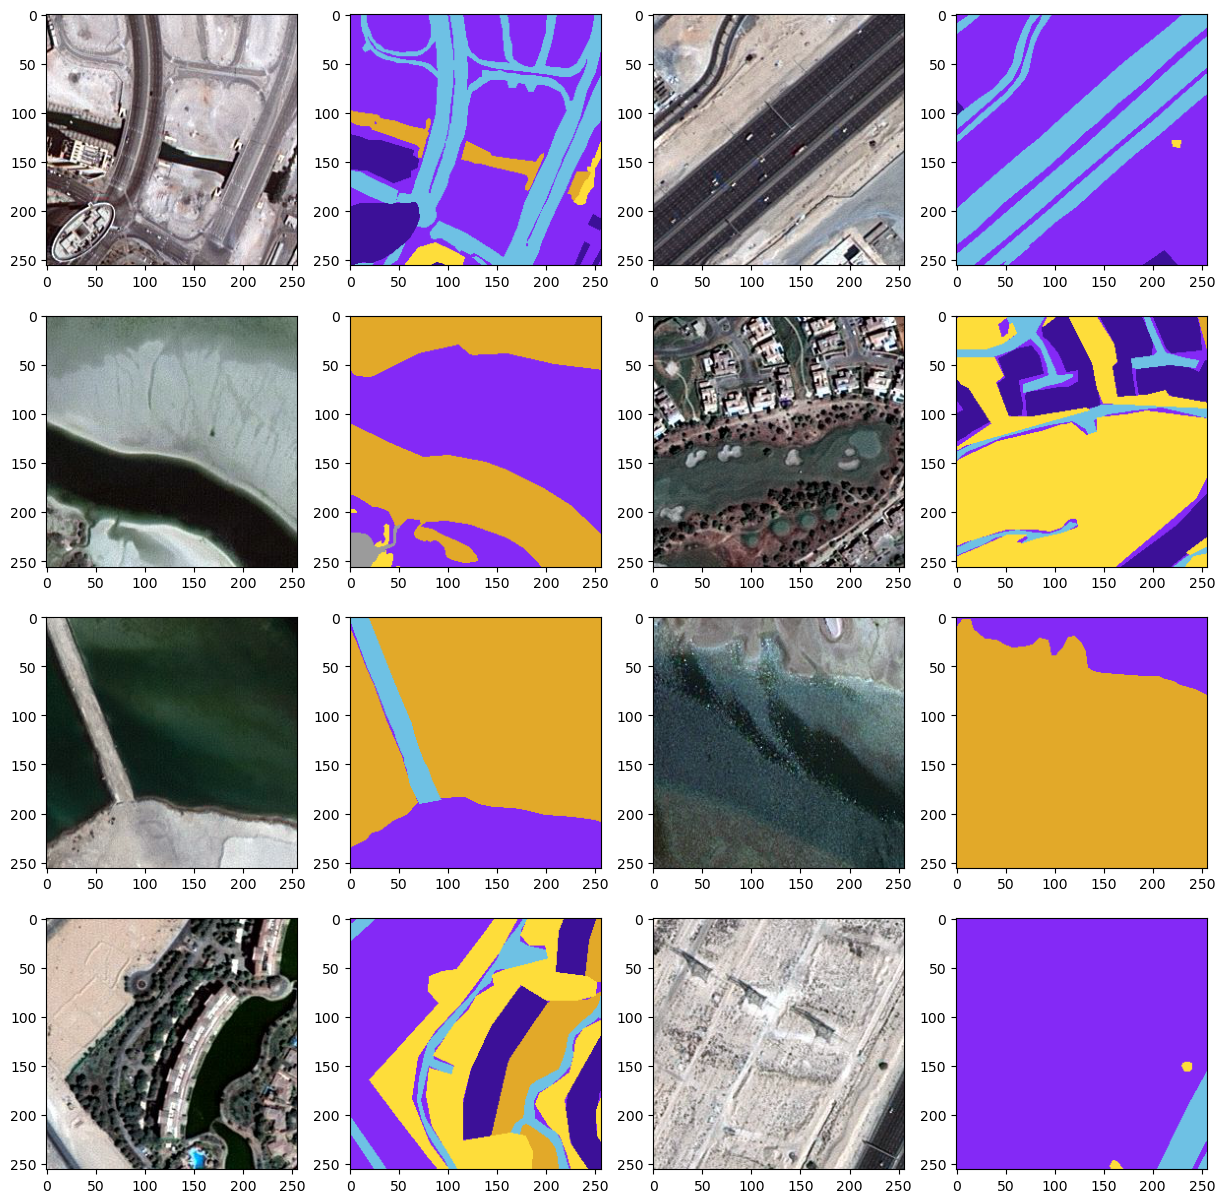

In [7]:
from matplotlib import pyplot as plt
import random
import itertools    

plt.figure(figsize=(15, 15))

n_rows = 4
n_cols = 2
        
for r, c in itertools.product(range(n_rows), range(n_cols)):
    
    idx = random.randint(0, images.shape[0])

    index = 2 * n_cols * r + 2 * c
    
    plt.subplot(n_rows, 2*n_cols, index+1)
    plt.imshow(images[idx])

    plt.subplot(n_rows, 2*n_cols, index+2)
    plt.imshow(masks[idx])   

## Color coding of masks

The masks are given as colored images, where each of the six classes has its own colors. The description of the dataset on kaggle specifies the color encoding of the classes in hexadecimal numbers:

- Building: #3C1098
- Land (unpaved area): #8429F6
- Road: #6EC1E4
- Vegetation: #FEDD3A
- Water: #E2A929
- Unlabeled: #9B9B9B

We therefore define a function that takes one of the above strings, converts this hexadecimal string into triples of RGB values, and returns these as a NumPy array.

In [8]:
def convert_hex_to_rgb(hex_code):
    return np.array(tuple(int(hex_code.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4)))

building_rgb = convert_hex_to_rgb('#3C1098')
land_rgb = convert_hex_to_rgb('#8429F6')
road_rgb = convert_hex_to_rgb('#6EC1E4')
vegetation_rgb = convert_hex_to_rgb('FEDD3A')
water_rgb = convert_hex_to_rgb('E2A929')
unlabeled_rgb = convert_hex_to_rgb('9B9B9B')

print('Building:  ', building_rgb)
print('Land:      ', land_rgb)
print('Road:      ', road_rgb)
print('Vegetation:', vegetation_rgb)
print('Water:     ', water_rgb)
print('Unlabeled: ', unlabeled_rgb)

Building:   [ 60  16 152]
Land:       [132  41 246]
Road:       [110 193 228]
Vegetation: [254 221  58]
Water:      [226 169  41]
Unlabeled:  [155 155 155]


We can now use these variables to identify all image pixels of the mask images that have these specific color codings. For example, all the land pixels. However, using just the equal comparison operator (`==`) would return a Boolean array that compares each pixel color individually.

In [9]:
(masks == land_rgb).shape

(1305, 256, 256, 3)

But we want all pixel values to be equal to indentify a specific color. Therefore, we combine the Boolean values for all three color values with the NumPy `all()` operator, which returns True if all values of a certain axis are True. (Like the AND operator.) We use the last axis (-1), which holds the color values. Now, we have a Boolean value for each pixel, and not for each pixel color value. Compare the shapes of the respective arrays.

In [10]:
np.all(masks == building_rgb, axis=-1).shape

(1305, 256, 256)

We can use such NumPy arrays (that result from the comparison above) to index the pixels of the masks that belong to a certain class (that has a specific color coding).

But before we go on, we inspect all the classes by summing up all the True values (pixels that have that specific color) of each class, and print them in order to see how many pixels we have for each class.

In [11]:
print('Building:  ', np.sum(np.all(masks == building_rgb, axis=-1)))
print('Land:      ', np.sum(np.all(masks == land_rgb, axis=-1)))
print('Road:      ', np.sum(np.all(masks == road_rgb, axis=-1)))
print('Vegetation:', np.sum(np.all(masks == vegetation_rgb, axis=-1)))
print('Water:     ', np.sum(np.all(masks == water_rgb, axis=-1)))
print('Unlabeled: ', np.sum(np.all(masks == unlabeled_rgb, axis=-1)))

Building:   11264087
Land:       45571963
Road:       7985171
Vegetation: 8743823
Water:      11116730
Unlabeled:  407840


If we add up all the above determined sums, then we notice that some pixels have none of the colors that represent a class. We can get the exact number by subtracting this number from the total number of pixels. (The total number of pixels are the number of patches * patch_size * patch_size, which are the first three dimensions of the masks array.)

In [12]:
(masks.shape[0] * masks.shape[1] * masks.shape[2]) - (
    np.sum(np.all(masks == building_rgb, axis=-1)) + 
    np.sum(np.all(masks == land_rgb, axis=-1)) +
    np.sum(np.all(masks == road_rgb, axis=-1)) +
    np.sum(np.all(masks == vegetation_rgb, axis=-1)) + 
    np.sum(np.all(masks == water_rgb, axis=-1)) +
    np.sum(np.all(masks == unlabeled_rgb, axis=-1))
)

434866

It seems that some mask pixels have the value (0, 0, 0), and are therefore not set to any mask color at all. We can verify this by comparing the mask pixels against an array of [0, 0, 0].

In [13]:
print(np.sum(np.all(masks == np.array([0,0,0]), axis=-1)))

434866


We need to take special care of these unset pixels when we convert the color values to class indices.

Next, we convert the color masks into (integer) mask labels 0 to 5. First, we construct an array of the same size as the masks, but with only one channel (for the class index) of type 8-bit unsigned integer. Then, we use the same index mechanism as above to set all pixels of the mask labels array to a specified class index. For assign the mask color values [0, 0, 0] to the same class as unlabeled pixels.

In [14]:
masks_labels = np.zeros((masks.shape[0], masks.shape[1], masks.shape[2] , 1), dtype=np.uint8)

masks_labels[np.all(masks == building_rgb, axis=-1)] = 0
masks_labels[np.all(masks == land_rgb, axis=-1)] = 1
masks_labels[np.all(masks == road_rgb, axis=-1)] = 2
masks_labels[np.all(masks == vegetation_rgb, axis=-1)] = 3
masks_labels[np.all(masks == water_rgb, axis=-1)] = 4
masks_labels[np.all(masks == unlabeled_rgb, axis=-1)] = 5
masks_labels[np.all(masks == np.array([0,0,0]), axis=-1)] = 5

masks_labels.shape

(1305, 256, 256, 1)

We could also define a function for the conversion, but we do not need that anymore in this notebook. However, we could use a inverse function that takes one image (and not a batch as we have above) of class indices and returns a RGB image with the color encoding for visualization purposes. 

**The only problem is that the originally unassigned mask values [0, 0, 0] will be colored with the unlabeled color, and not with the black color. So, keep this in mind when visualising the data.**

In [15]:
def label_to_rgb(label_image):

    label_rgb = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.uint8)
    
    label_rgb[np.all(label_image == 0, axis=-1)] = building_rgb
    label_rgb[np.all(label_image == 1, axis=-1)] = land_rgb
    label_rgb[np.all(label_image == 2, axis=-1)] = road_rgb
    label_rgb[np.all(label_image == 3, axis=-1)] = vegetation_rgb
    label_rgb[np.all(label_image == 4, axis=-1)] = water_rgb
    label_rgb[np.all(label_image == 5, axis=-1)] = unlabeled_rgb

    return label_rgb

Let us check the mask label images by displaying some random images. Besides the aerial image, we display the original mask, the converted masks with integer labels, and the integer label masks that are convertex back to the color coding to check that everything worked accordingly.

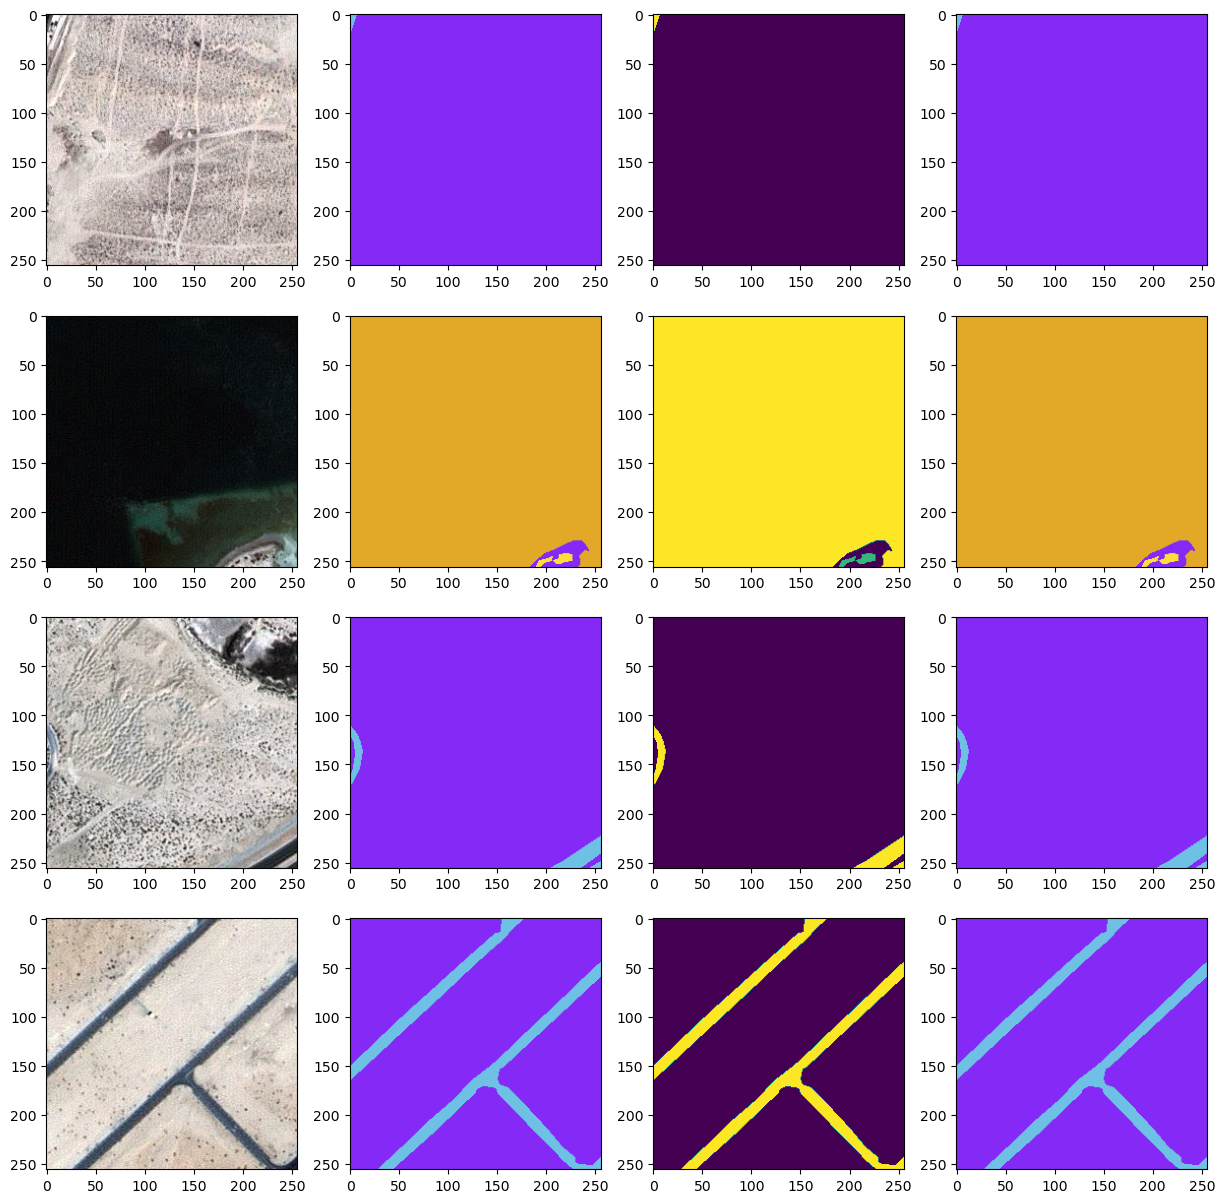

In [16]:
plt.figure(figsize=(15, 15))

n_rows = 4
n_cols = 4        
    
for i in range(n_rows):
    
    idx = random.randint(0, images.shape[0])

    index = i * n_cols
    
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(images[idx])

    plt.subplot(n_rows, n_cols, index+2)
    plt.imshow(masks[idx])   

    plt.subplot(n_rows, n_cols, index+3)
    plt.imshow(masks_labels[idx])
    
    plt.subplot(n_rows, n_cols, index+4)
    plt.imshow(label_to_rgb(masks_labels[idx]))

The second and fourth column should be identical with the exception that sometimes pixels that were originally black are now gray, because of the problem we discovered above. The third column displays the masks with integer class indices. Be careful that the coloring of the classes is not consistend over the images. It seems that some classes are plotted in different colors if some classes are not present in the image. For example, if class 3 is missing, then class 4 would get the color of class 3 instead, compared to an image with all classes present. That is also the reason why we convert the masks with class labels back to RGB images to better compare them to the original masks.

Before we train our network, let us inspect the frequencies of the classes with a histogram.

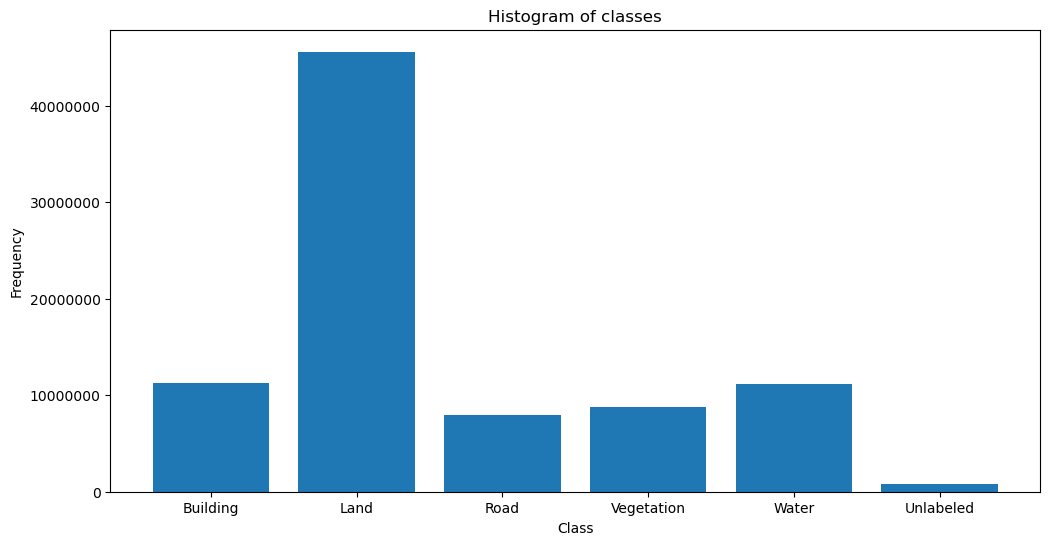

In [17]:
unique = np.array(np.unique(masks_labels, return_counts=True))

label_names = ["Building", "Land", "Road", "Vegetation", "Water", "Unlabeled"]

plt.figure(figsize=(12, 6))
plt.bar(label_names, unique[1])

plt.ticklabel_format(axis="y", style='plain')
plt.title('Histogram of classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
_ = plt.show

We notice, there are quite large differences between classes. Although we have unbalanced classes, we will not address this problem any further.

As a last step in the data pre-processing, we convert the integer masks with values between 0 and 5 to a one-hot encoding that our network will take for training. Therefore, we first get the number of unique labels from the mask label images, and apply the masks to the `to_categorical` function of TensorFlow.

In [18]:
from tensorflow.keras.utils import to_categorical
import numpy as np

unique_labels = np.unique(masks_labels)
num_classes = len(unique_labels)

one_hot_encoded_masks = to_categorical(masks_labels, num_classes=num_classes)

And we also split the data into training and testing, where the latter is actually validation data. Therefore, we do not have real test data, and just take the validation scores from the test data.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, one_hot_encoded_masks, test_size=0.25, random_state=42)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(978, 256, 256, 3)
(978, 256, 256, 6)
(327, 256, 256, 3)
(327, 256, 256, 6)


## Construct and train model

So far, all neural network models we have implemented use the Sequential API, which are limited to a sequence of layers, where each layer takes one input (tensor from the previous layer) and produces one output (tensor that serves as input to the next layer). However, many of the more elaborate networks take several inputs, have several parallel paths, and produce multiple outputs. For the U-Net architecture, we need to implement skip connections that forward feature maps to layers that are further back in the network.

The Functional API is not much more difficult than the Sequential API, and you use the same layer classes as before. You always start by constructing an object of the `Input` layer class (or several thereof), and then you input the **returned tensor object** as input to the next layer you construct, and that follows the previous layer. This continues on until you have all layers defined. Only in the end, you take the input tensor(s) and the output tensor(s), and construct a `Model` object, where you provide a **list of input tensors** to the `inputs` parameter, and a **list of output tensors** to the `outputs` parameter.

It is common practice to reuse variable names. So, you often see that a variable holding a tensor is used as input to a newly constructed layer and the resulting tensor of this newly constructed layer is again assigned to this variable. Only if the variable is used later on as input to a layer that comes further down the network, then this variable must not be re-assigned, since then the tensor would be lost.

In the following, a U-Net style neural network is constructed with four convolutional downsampling layers, and then four transpose convolutional upsampling layers. For downsampling, `MaxPooling2D` layers are used, and for upsampling, `Conv2DTranspose` layers are used with filter sizes (2,2) and strides (2,2), which effectively doubles the size of the input tensors in both dimensions. The skip connections are implemented with the `Concatenate` layer, which you provide a list of tensors that you want to concatenate (combine channel-wise). Here, we contacenate the output of the previous layer with the last output of the layer before max pooling, which is located at the same downsampling level as the current upsampling level. The tensors you want to concatenate must have the same width and height. All the convolutional layers have zero padding, and are initialized with the He normal initializer.

The last layer of the semantic segmentation network is a 2D convolutional layer with as many filters as there are output classes and filter size (1,1), which produces the class probabilities for each pixel. The first channel holds the probability of the first class, the second the probability of the second class, etc.

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Concatenate, Conv2DTranspose

inputs = Input((patch_size, patch_size, 3))

# downsampling
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# same as above with 32 filters
c2 =
c2 =
c2 =
p2 =

# same as above with 64 filters
c3 = 
c3 = 
c3 = 
p3 = 

# same as above with 128 filters
c4 = 
c4 = 
c4 = 
p4 = 

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# upsampling
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# same as above with 64 filters (just be sure to concatenate the right tensors)
u7 = 
u7 = 
c7 = 
c7 = 
c7 = 

# same as above with 32 filters (just be sure to concatenate the right tensors)
u8 = 
u8 = 
c8 = 
c8 = 
c8 = 

# same as above with 16 filters (just be sure to concatenate the right tensors)
u9 = 
u9 = 
c9 = 
c9 = 
c9 = 

# pixel-wise class probabilities
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
    
model.summary()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate,Dropout
from tensorflow.keras import layers, models

def unet_multi_class(input_size=(patch_size, patch_size, 3), num_classes=6):
    
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Expansive Path (Decoder)
    up5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model


model = unet_multi_class( input_size=(patch_size, patch_size, 3), num_classes=6)  # Change num_classes as needed
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

2024-01-31 16:54:54.085629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14744 MB memory:  -> device: 6, name: Quadro RTX 5000, pci bus id: 0000:c1:00.0, compute capability: 7.5


Before we can train the network, we need to define a loss function. Here, we use a combination of the Dice loss and the categorical focal loss. The Dice loss favours crisp boundaries, while the focal loss helps to focus the learning process on the hard to classify samples, especially when having imbalanced classes. For both loss components, we use the classes from the Segmentation Models library. And the total loss is just the sum of the two components.

In [22]:
os.environ['SM_FRAMEWORK']='tf.keras' # tell the Segmentation Models library to use keras
import segmentation_models as sm

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

Segmentation Models: using `tf.keras` framework.


Configure the model for training by specifying the optimizer, loss, and metrics. For the metrics, we use accuracy, and the mean Intersection over Union (mIoU) metric. Since our labels are provided as one-hot encoding, the `OneHotMeanIoU` class is used.

In [23]:
from keras.metrics import *

metrics=['accuracy', tf.keras.metrics.OneHotMeanIoU(
    num_classes= 6,
    name='mIoU',
    sparse_y_pred= bool == False
)]


model.compile(
    optimizer='Nadam',
    loss=total_loss,
    metrics= metrics,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    jit_compile=None
)


Now, its time to train the network for (let's say) 100 epochs.

In [24]:
history = model.fit(X_train, y_train,batch_size=16,verbose=1,epochs=100,validation_data=(X_test, y_test),shuffle=False)

Epoch 1/100


2024-01-31 16:55:04.052920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2024-01-31 16:55:13.546273: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3f947389d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 16:55:13.546336: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-01-31 16:55:13.553449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-31 16:55:13.681799: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - 48s 423ms/step - loss: 0.9876 - accuracy: 0.5941 - mIoU: 0.2182 - val_loss: 0.9629 - val_accuracy: 0.7053 - val_mIoU: 0.3315
Epoch 2/100
62/62 [==============================] - 21s 338ms/step - loss: 0.9558 - accuracy: 0.7124 - mIoU: 0.3751 - val_loss: 0.9462 - val_accuracy: 0.7567 - val_mIoU: 0.4146
Epoch 3/100
62/62 [==============================] - 21s 344ms/step - loss: 0.9444 - accuracy: 0.7532 - mIoU: 0.4351 - val_loss: 0.9383 - val_accuracy: 0.7757 - val_mIoU: 0.4538
Epoch 4/100
62/62 [==============================] - 21s 347ms/step - loss: 0.9361 - accuracy: 0.7786 - mIoU: 0.4710 - val_loss: 0.9334 - val_accuracy: 0.7891 - val_mIoU: 0.4713
Epoch 5/100
62/62 [==============================] - 21s 343ms/step - loss: 0.9281 - accuracy: 0.7994 - mIoU: 0.5033 - val_loss: 0.9290 - val_accuracy: 0.7989 - val_mIoU: 0.4883
Epoch 6/100
62/62 [==============================] - 21s 343ms/step - loss: 0.9248 - accuracy: 0.8073 - mIoU: 0.5162 - val

As you notice, although the accuracy is quite high, the mean IoU remains at around 60% for the validation (test) data. This is not that bad as the IoU values are always quite low.

Let us have a look at the training history by plotting the loss and the mIoU versus the epochs.

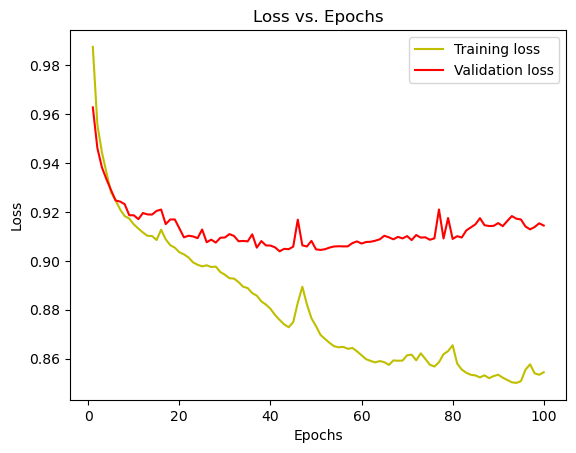

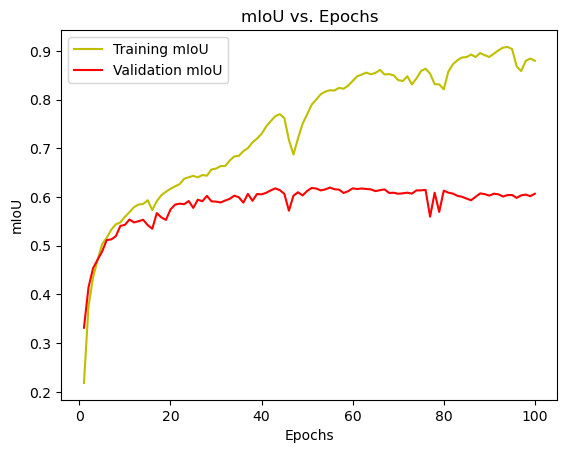

In [25]:
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'y', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['mIoU'], 'y', label='Training mIoU')
plt.plot(epochs, history.history['val_mIoU'], 'r', label='Validation mIoU')
plt.title('mIoU vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()
plt.show()

**Question 1: From which epoch on do you see no further improvement in the network? What happened?** 

Now, let us also take a look at the prediced masks and compare them with the ground truth masks. (The code for that is not that straight-forward, as we need to take the images and masks from the test data, and especially the masks (also for the ground truth masks), we need to go through the whole process of determining the class index with the highest score/probability, add another dimension so that we have a tensor of shape (patch_size, patch_size, 6), and convert the labels to RGB values.

1/1 [==============================] - 1s 1s/step


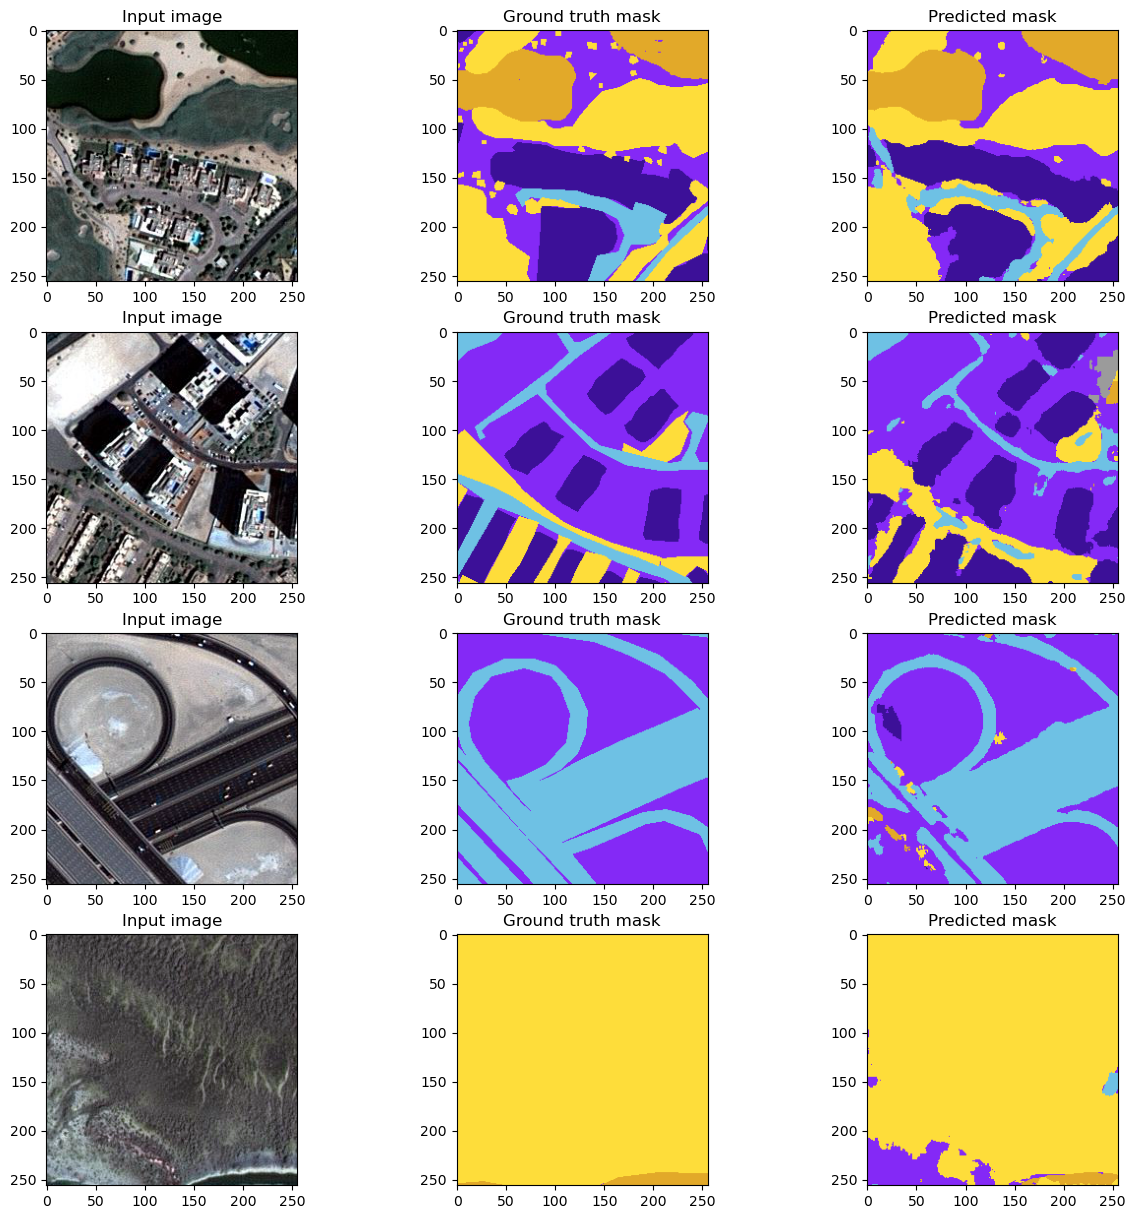

In [26]:
plt.figure(figsize=(15, 15))

n_rows = 4
n_cols = 3
        
# make n_rows predictions
rnd_arr = np.random.randint(X_test.shape[0], size=4)
pred = model.predict(X_test[rnd_arr])
    
for r in range(n_rows):
    
    index = n_cols * r
    
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(X_test[rnd_arr[r]])
    plt.title('Input image')

    plt.subplot(n_rows, n_cols, index+2)
    plt.imshow(label_to_rgb(np.expand_dims(np.argmax(y_test[rnd_arr[r]], axis=-1), axis=-1)))
    plt.title('Ground truth mask')
    
    plt.subplot(n_rows, n_cols, index+3)
    plt.imshow(label_to_rgb(np.expand_dims(np.argmax(pred[r], axis=-1), axis=-1)))
    plt.title('Predicted mask')

Although not perfect, the predictions are somewhat close to the ground truth masks. But the whole process leaves room for improvements: The data could be much more, the neural network is rather simple, and the labeling is also very coarse. For example, there seems to be vegetation in between buildings, but the areas are largely labeled as big building areas. By cropping the image and mask data, we already throw away some portions of the valuable training data, and we do not perform any data augmentation.

# The Segmentation Models library

In the second part of this notebook, we use the Segmentation Models library to construct and train a neural network for semantic segmentation with some common architectures. See the [GitHub](https://github.com/qubvel/segmentation_models) repository for some figures of the architectures that are provided in the Segmentation Models library.

We first have to choose a backbone for the neural network, like ResNet34 (`resnet34`), VGG16 (`vgg16`), Inception (`inceptionv3`), or any other one from the many choices. As the different backbones might have specific requirements on the input data, we first get a preprocessing function from the library with the `get_preprocessing()` function, and apply this function on our data.

In [32]:
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_sm = preprocess_input(X_train)
X_test_sm = preprocess_input(X_test)

Next, we construct a neural network model of our choice (`Unet`, `Linknet`, `PSPNet`, `FPN`) using the respective function, specifying the (just chosen) backbone network, the pre-trained weights we want to use (here from ImageNet), the number of output classes, and the activation function of the last layer (in case we want to have a binary classification or work with logits). You can choose any of the four network models by commenting out Unet and uncommenting any of the other architectures, although PSPNet requires larger images of size 384x384. (On first construction, the pre-trained weights might be downloaded.)

In [28]:
sm_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes,activation='softmax')


# remember the model name for later to descibe our plots
model_string = 'U-Net'

In case you are interested in the details of the network, you can use the `summary()` method on the model.

Finally, after configuring the training process, the network can be fit to our pre-processed data.

In [29]:
sm_model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

history = sm_model.fit(X_train_sm,y_train,batch_size=16,epochs=100,validation_data=(X_test_sm, y_test),shuffle=False)

Epoch 1/100
62/62 [==============================] - 39s 229ms/step - loss: 0.9641 - accuracy: 0.6928 - mIoU: 0.4201 - val_loss: 1.5726 - val_accuracy: 0.1304 - val_mIoU: 0.0227
Epoch 2/100
62/62 [==============================] - 10s 164ms/step - loss: 0.9313 - accuracy: 0.7875 - mIoU: 0.4875 - val_loss: 1.1214 - val_accuracy: 0.1488 - val_mIoU: 0.0248
Epoch 3/100
62/62 [==============================] - 11s 176ms/step - loss: 0.9225 - accuracy: 0.8123 - mIoU: 0.5269 - val_loss: 1.1243 - val_accuracy: 0.0976 - val_mIoU: 0.0166
Epoch 4/100
62/62 [==============================] - 11s 176ms/step - loss: 0.9177 - accuracy: 0.8237 - mIoU: 0.5449 - val_loss: 1.0438 - val_accuracy: 0.2286 - val_mIoU: 0.0605
Epoch 5/100
62/62 [==============================] - 11s 174ms/step - loss: 0.9136 - accuracy: 0.8337 - mIoU: 0.5617 - val_loss: 1.0564 - val_accuracy: 0.5387 - val_mIoU: 0.0898
Epoch 6/100
62/62 [==============================] - 10s 169ms/step - loss: 0.9108 - accuracy: 0.8393 - mIoU: 

Check the loss and mIoU versus the epochs to see how the metrics developed over the training process.

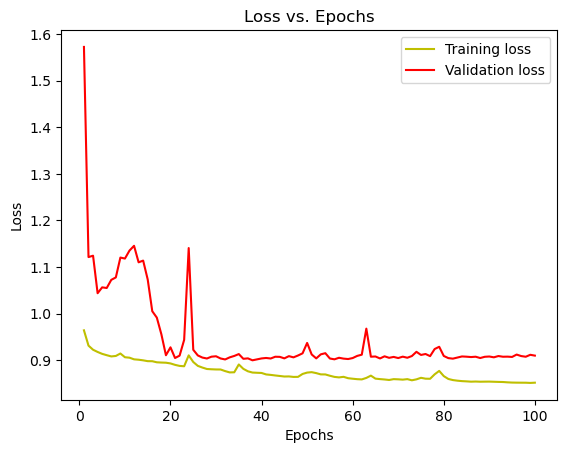

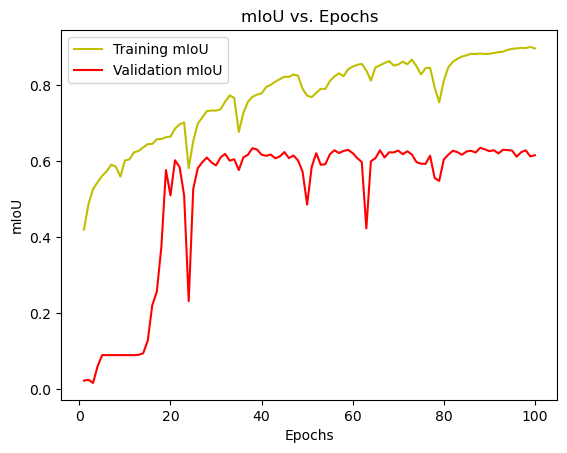

In [30]:
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'y', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history.history['mIoU'], 'y', label='Training mIoU')
plt.plot(epochs, history.history['val_mIoU'], 'r', label='Validation mIoU')
plt.title('mIoU vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()
plt.show()

It seems like the training process did not improve the network for unseen data starting somewhere between epochs 20 and 30.

1/1 [==============================] - 1s 1s/step


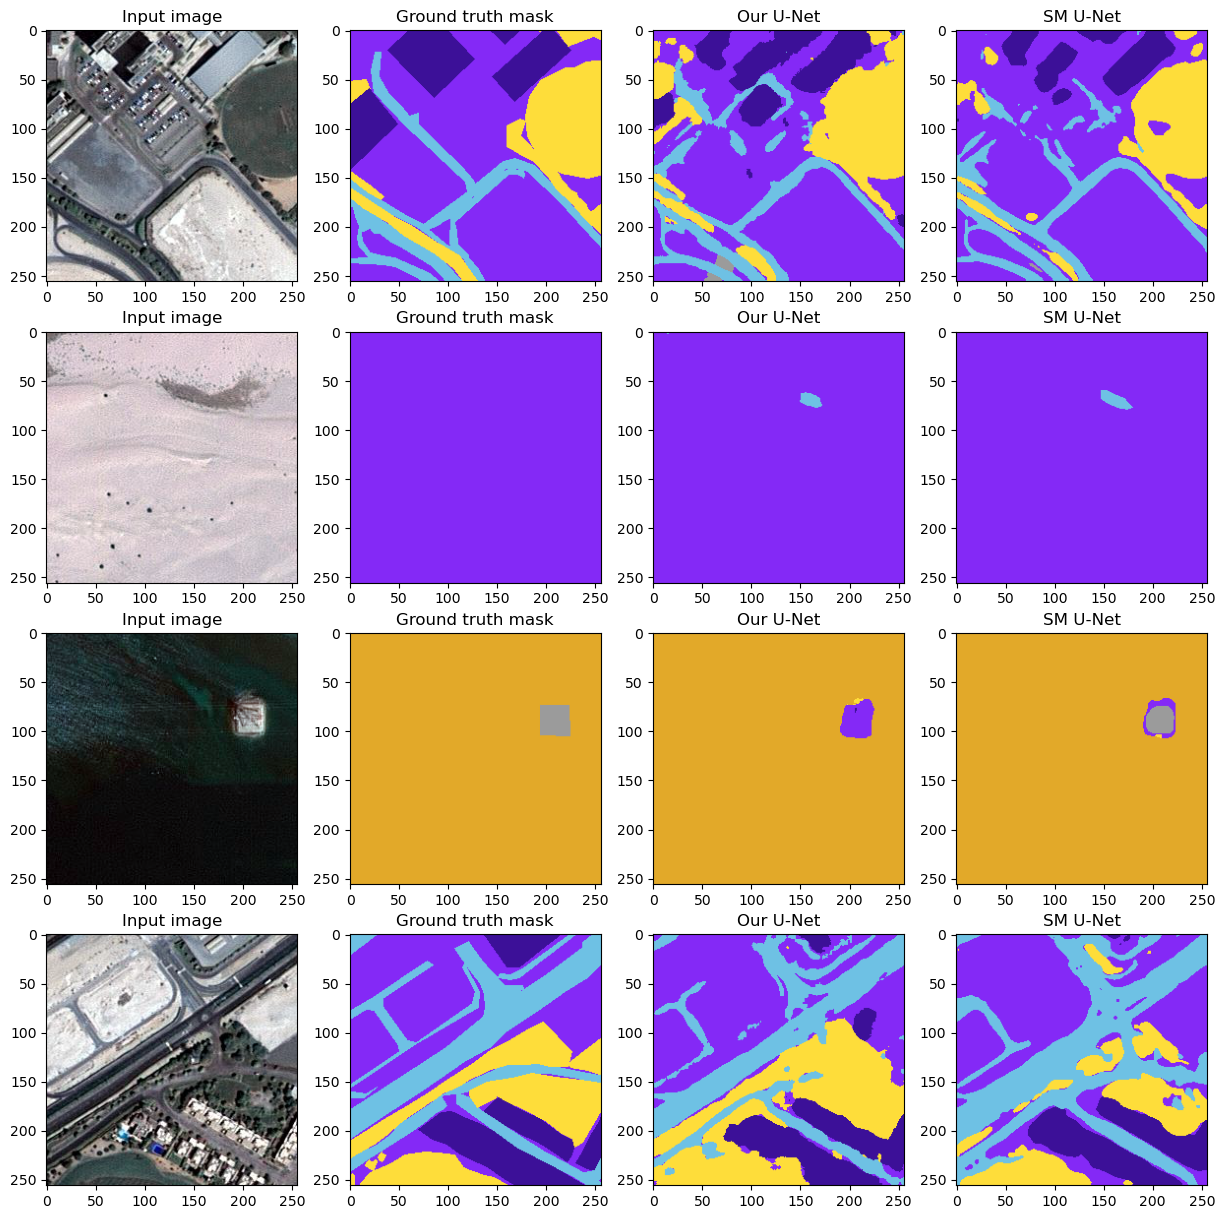

In [31]:
plt.figure(figsize=(15, 15))

n_rows = 4
n_cols = 4

# make n_rows predictions for model 1 and model 2
rnd_arr = np.random.randint(X_test_sm.shape[0], size=4)
pred1 = model.predict(X_test[rnd_arr])
pred2 = sm_model.predict(X_test_sm[rnd_arr])

for r in range(n_rows):
    
    index = n_cols * r
    
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(X_test[rnd_arr[r]])
    plt.title('Input image')

    plt.subplot(n_rows, n_cols, index+2)
    plt.imshow(label_to_rgb(np.expand_dims(np.argmax(y_test[rnd_arr[r]], axis=-1), axis=-1)))
    plt.title('Ground truth mask')

    plt.subplot(n_rows, n_cols, index+3)
    plt.imshow(label_to_rgb(np.expand_dims(np.argmax(pred1[r], axis=-1), axis=-1)))
    plt.title('Our U-Net')    
    
    plt.subplot(n_rows, n_cols, index+4)
    plt.imshow(label_to_rgb(np.expand_dims(np.argmax(pred2[r], axis=-1), axis=-1)))
    plt.title('SM ' + model_string)

From the plotted results, it should become visible that the results of both approaches are similar, where the networks from the Segmentation Models library maybe perform a little better. 

# Intersection over Union

In the last part of this notebook, we explore the Intersection over Union (IoU) metric, and later on calculate the IoU values for each class by hand. But first, we use the `MeanIoU` class of Tensorflow to calculate the mean Intersection over Union. For this purpose, we need to construct the `MeanIoU` class with the number of classes, and then use the `update_state()` method to accumulate the confusion matrix statistics from which the mean IoU is calculated. The function takes the class indices of the true labels and of the predicted labels. The `result()` method gives the mean IoU value.

In [33]:
from tensorflow.keras.metrics import MeanIoU

y_pred = sm_model.predict(X_test_sm)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_test_argmax = np.argmax(y_test, axis=-1)
mIOU = MeanIoU(num_classes=6)

mIOU.update_state(y_test_argmax, y_pred_argmax)
print("mIoU =", mIOU.result().numpy())

11/11 [==============================] - 3s 64ms/step
mIoU = 0.6158809


We can also calculate the Intersection over Union for each class with the `IoU` class of TensorFlow. We therefore construct an `IoU` object, specifying the number of classes and the target class ids that we are interested in to calculate the IoU for. If one target class id is specified, it gives the IoU for this class. If several classes are specified, it gives the mean IoU for these classes. We update the confusion matrix statistics and get the result as in the MeanIoU class above.

In [38]:
from tensorflow.keras.metrics import IoU

for i, n in zip(range(num_classes), label_names):
    IOU = IoU(num_classes, target_class_ids=[i])
    IOU.update_state(y_test_argmax, y_pred_argmax)

    print(f'IoU for class {n:<11}: {IOU.result().numpy():<.6f}')

IoU for class Building   : 0.680293
IoU for class Land       : 0.834271
IoU for class Road       : 0.605500
IoU for class Vegetation : 0.609563
IoU for class Water      : 0.888241
IoU for class Unlabeled  : 0.077417


To calculate all the above IoU metrics by hand, we use the `confusion_matrix()` function of sklearn, which we provide the same test and predicted labels as input. However, the confusion_matrix() function needs a flattened array instead of tensor with 3D shape.

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

cm

array([[ 2067883,   415868,    67786,   133622,      810,    14469],
       [  234521, 10833097,   272195,   154868,    31940,    18156],
       [   16773,   364260,  1378827,    16825,     1270,     1257],
       [   66787,   318348,   143404,  1464704,    56960,      760],
       [    4549,   220191,     6700,    42603,  2913485,        0],
       [   16626,   121669,     7875,     3994,     1552,    15638]])

To get a nicer output of the confusion matrix, we can use the Pandas library and construct a `DataFrame` object from the confusion matrix, with the label names given for both the column names and row indices.

In [40]:
import pandas as pd

pd.DataFrame(cm, columns=label_names, index=label_names)

Building      Land     Road  Vegetation    Water  Unlabeled
Building     2067883    415868    67786      133622      810      14469
Land          234521  10833097   272195      154868    31940      18156
Road           16773    364260  1378827       16825     1270       1257
Vegetation     66787    318348   143404     1464704    56960        760
Water           4549    220191     6700       42603  2913485          0
Unlabeled      16626    121669     7875        3994     1552      15638

From this confusion matrix, we can notice that buildings are captured in a good way, but are also often misclassified as land or vegetation, and vice versa. This does not surprise as the labeling of the buildings is rather poor and contains many pixels that are actually land or vegetation. Land and water generally work much better. Then, road is again often misclassified as land or vegetation. And unlabeled does not work that good, maybe to some extend because we assigned the unlabeled pixels to this class.

The Intersection over Union for each class can be computed as follows:

$$\frac{TP}{TP+FP+FN}$$

- The TP (true positives) of a class is stored in the diagonal of the confusion matrix. It notes how many elements of the class have been predicted correctly.
- The FP (false positives) of a class is the sum of the elements in the column (of this class) in the confusion matrix (without the diagonal). It notes how many elements of other classes have been incorrectly predicted to belong to this class.
- The FN (false negatives) of a class is the sum of the elements in the row (of this class) in the confusion matrix (without the diagonal). It notes how many elements of the class have been predicted incorrectly, meaning that a different class has been predicted for this class.

The following cell shows the calculation from the confusion matrix written out for the case of six classes.

In [41]:
class1_IoU = cm[0,0] / (cm[0,0] + cm[0,1] + cm[0,2] + cm[0,3] + cm[0,4] + cm[0,5] + cm[1,0]+ cm[2,0]+ cm[3,0] + cm[4,0] + cm[5,0])
class2_IoU = cm[1,1] / (cm[1,1] + cm[1,0] + cm[1,2] + cm[1,3] + cm[1,4] + cm[1,5] + cm[0,1]+ cm[2,1]+ cm[3,1] + cm[4,1] + cm[5,1])
class3_IoU = cm[2,2] / (cm[2,2] + cm[2,0] + cm[2,1] + cm[2,3] + cm[2,4] + cm[2,5] + cm[0,2]+ cm[1,2]+ cm[3,2] + cm[4,2] + cm[5,2])
class4_IoU = cm[3,3] / (cm[3,3] + cm[3,0] + cm[3,1] + cm[3,2] + cm[3,4] + cm[3,5] + cm[0,3]+ cm[1,3]+ cm[2,3] + cm[4,3] + cm[5,3])
class5_IoU = cm[4,4] / (cm[4,4] + cm[4,0] + cm[4,1] + cm[4,2] + cm[4,3] + cm[4,5] + cm[0,4]+ cm[1,4]+ cm[2,4] + cm[3,4] + cm[5,4])
class6_IoU = cm[5,5] / (cm[5,5] + cm[5,0] + cm[5,1] + cm[5,2] + cm[5,3] + cm[5,4] + cm[0,5]+ cm[1,5]+ cm[2,5] + cm[3,5] + cm[4,5])

print("IoU for class Building   :", f'{class1_IoU:<.6f}')
print("IoU for class Land       :", f'{class2_IoU:<.6f}')
print("IoU for class Road       :", f'{class3_IoU:<.6f}')
print("IoU for class Vegetation :", f'{class4_IoU:<.6f}')
print("IoU for class Water      :", f'{class5_IoU:<.6f}')
print("IoU for class Unlabeled  :", f'{class6_IoU:<.6f}')

IoU for class Building   : 0.680293
IoU for class Land       : 0.834271
IoU for class Road       : 0.605500
IoU for class Vegetation : 0.609563
IoU for class Water      : 0.888241
IoU for class Unlabeled  : 0.077417


When you compare the self-computed values with the ones above from the IoU class, you should see almost no difference besides maybe small rounding errors in the last digit.

We can also calculate all IoU values using NumPy vector operations as shown in the following. The TP are the diagonals of the matrix, the FP is the sum of the elements in each column (without the diagnoal), and the FN the sum of the elements in each row (without the diagnoal). We simply sum up the whole row and the whole column. Because the two sums each contain the diagonal elements, these elements are once too often in the sums, and we need to subtract the TP instead of adding it. The calculation of the denominator then becomes (FP_plus_TP+FN_plus_TP-TP). However, the formula is still the same as above. So, please do not confuse the definition and how we calculate it with vector operations.

In [42]:
TP = cm.diagonal()
FN_plus_TP = np.sum(cm, axis=1)
FP_plus_TP = np.sum(cm, axis=0)
# we have to subtract TP instead of adding it, because we
# have TP in FP and FN already
IoU = TP / (FP_plus_TP + FN_plus_TP - TP)

for l, iou in zip(label_names, IoU):
    print(f'IoU for class {l:<11}: {iou:<.6f}')


IoU for class Building   : 0.680293
IoU for class Land       : 0.834271
IoU for class Road       : 0.605500
IoU for class Vegetation : 0.609563
IoU for class Water      : 0.888241
IoU for class Unlabeled  : 0.077417


The values are the same, but the code is much smaller and cleaner. Last, the mean Intersection over union

What we see from the IoU values is that the land and water class work fine, the building class is still somewhat good, road and vegetation classes are satisfactory, and the unlabeled class is really bad.

Finally, let us take the mean of the IoU per class with the NumPy `mean()` function, which should give us the same value as above from the MeanIoU class (and also what the last epoch showed as validation metrics).

In [43]:
print('mIoU:', np.mean(IoU))

mIoU: 0.6158808769874985


This concludes the notebook. You can train the neural networks once more for a smaller number of epochs, so that the models do not overfit too much, and compare if the visualized (plotted) results are in any way better than before.

## Answers to questions

**Question 1: From which epoch on do you see no further improvement in the network?  What happened?**
Although the training loss and mIoU continues to improve over the whole training process, these metrics do not improve much for the validation data anymore starting around epoch 40. This is where the network is very likely overfitting the training data, and we could stop training between epochs 35 and 40. It is questionable if the 1% improvement in mIoU that we observe over the next 55 to 60 epochs for the validation data will generalize well for unseen data.